In [2]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import scipy.misc


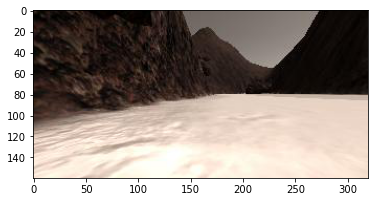

In [3]:
path = "../test_dataset/IMG/*"
img_list = glob.glob(path)
idx = np.random.randint(0,len(img_list)-1)
grid_img  = mpimg.imread(img_list[idx])
plt.imshow(grid_img )

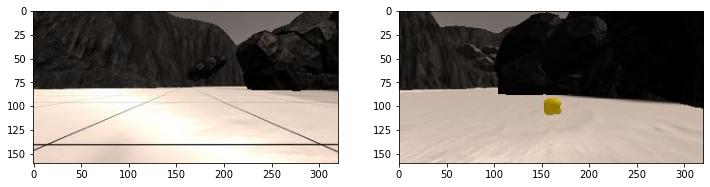

In [157]:
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"

grid_image = mpimg.imread(example_grid)
rock_image = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot((121))
plt.imshow(grid_image)
plt.subplot((122))
plt.imshow(rock_image)

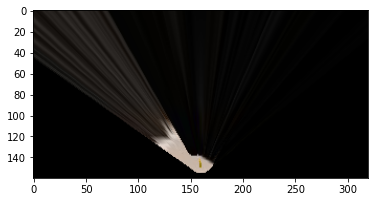

In [158]:
def perspect_transform(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M , (img.shape[1], img.shape[0]))
    
    return warped


dst_size = 3
butt_ofset = 5;
source = np.float32([  [14,  175],
                       [300, 175],
                       [210, 105],
                       [125, 105]
                    ])
destination = np.float32([
    [rock_image.shape[1] / 2 - dst_size, rock_image.shape[0]-butt_ofset],
    [rock_image.shape[1] / 2 + dst_size, rock_image.shape[0]-butt_ofset],
    [rock_image.shape[1] / 2 + dst_size, rock_image.shape[0]-2*dst_size -butt_ofset],
    [rock_image.shape[1] / 2 - dst_size, rock_image.shape[0]-2*dst_size -butt_ofset]
])
warped = perspect_transform(rock_image, source, destination)
plt.imshow(warped)


    

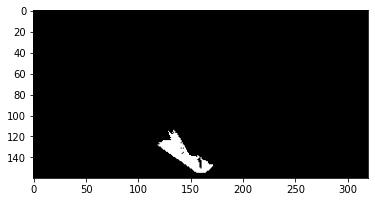

In [159]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    color_select = np.zeros_like(img[:,:,0])

    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])

    color_select[above_thresh] = 1
    return color_select

threshold = color_thresh(warped)
plt.imshow(threshold,cmap="gray")


In [1]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world



#grab another random image
index = np.random.randint(0,len(img_list)-1)
image = mpimg.imread(img_list[index])
warped = perspect_transform(image,source,destination)
map_view = cv2.GaussianBlur(warped,(31,31),0)
threshold = color_thresh(map_view)

#calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix,ypix = rover_coords(threshold)
dist,angles = to_polar_coords(xpix,ypix)
mean_dir = np.mean(angles)

worldmap_path = "../calibration_images/map_bw.png"
worldmap = mpimg.imread(worldmap_path)
scale = 10

import pandas
df = pandas.read_csv("../test_dataset/robot_log.csv")
data_dict = df.to_dict()
mylist = data_dict["Path;SteerAngle;Throttle;Brake;Speed;X_Position;Y_Position;Pitch;Yaw;Roll"][index].split(";")

xpos = float(mylist[5])
ypos = float(mylist[6])
yaw = float(mylist[8])

navigable_x_world, navigable_y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, worldmap.shape[0], scale)

worldmap[navigable_y_world, navigable_x_world] += 10
print(index)

#do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshold,cmap="gray")
plt.subplot(224)
plt.plot(xpix,ypix,'.')
plt.ylim(-160,160)
plt.xlim(0,160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0,0,x_arrow,y_arrow,color='red',zorder=2,head_width=10,width=2)

fig2 = plt.figure(figsize=(12, 9))
plt.subplot(221)
plt.imshow(worldmap)



NameError: name 'np' is not defined